In [2]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class CustomMultiImageDataset(Dataset):
    def __init__(self, csv_path,):
        self.data = pd.read_csv(csv_path,header=None,sep=',',index_col=0)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.values[idx]
        return torch.from_numpy(sample).to(torch.float32)

# Normalizing flows
<div style="border-radius:10px; border:#7887e3 solid; padding: 15px; font-size:100%; text-align:left">
<b><p>A normalizing flow transforms a simple distribution into a complex one by applying a sequence of invertible transformation functions. Flowing through a chain of transformations, we repeatedly substitute the variable for the new one according to the change of variables theorem and eventually obtain a probability distribution of the final target variable.</p></b>
<img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/normalizing-flow.png" alt="Alternative text" width=500px height=500px />

## RealNVP
<div style="border-radius:10px; border:#7887e3 solid; padding: 15px; font-size:100%; text-align:left">
<b><p>RealNVP is a generative model that utilises real-valued non-volume preserving (real NVP) transformations for density estimation. The model can perform efficient and exact inference, sampling and log-density estimation of data points.</p></b>

In [5]:
class Base_model(nn.Module):
    """
    feed forward network for defining the operations of scaling and translation needed in realnvp
    """
    def __init__(self,in_dim=2,out_dim=2,hidden_dim=8):
        super(Base_model,self).__init__()
        self.fcn = nn.Sequential(
                nn.Linear(in_dim,hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim,hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim,out_dim),
        )        
        self.initialize_weights()
    def forward(self, x):
        y = self.fcn(x)
        return y
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)

<div style="border-radius:10px; border:#7887e3 solid; padding: 15px; font-size:100%; text-align:left">

$$\Large \{^ {\large \displaystyle x_{1:d} \displaystyle = z_{1:d}}_{\large \displaystyle x_{d+1:D} \displaystyle=  z_{d+1:D}\odot\exp(z_{1:d}) +t(z_{1:d})}  \Longleftrightarrow \huge \{^ {\large \displaystyle z_{1:d} \displaystyle = x_{1:d}}_{\large \displaystyle z_{d+1:D} \displaystyle=  (x_{d+1:D}-+t(z_{1:d}))\odot\exp(-s_{1:d}) }$$

<b><p>t and s are Feed forward neural networks and d is an int number smaller than D.</p></b>
<b><p>Partitioning can be implemented using a binary mask b, and using the functional form for y : </p></b>
$$\large x = b\odot z +(1-b) \odot (z\odot s(z\odot b)+t(z\odot b))$$

<b><p>The jacobian is expressed as :</p></b>
$$\large J = \begin{bmatrix}
 I_d  &  0 \\ 
 \frac{\partial y_{d+1:D} }{\partial z^T_{1:d}}&  diag(\exp[s(x_{1:d}))]
\end{bmatrix}$$
<b><p>So the log-determinant : </p></b> $$\large Logdet = \sum_{j=1}^{D-d}\exp[s(x_{1:d})]_j$$

In [6]:
class Coupling_layer(nn.Module):
    """Coupling layer in RealNVP.

    Args:
        dim (int): Number of channels in the input.
        hidden_dim (int): Number of channels in the `s` and `t` network.
        mask_type (tensor): binary mask to have in track what value should be kept inchanged
    """
    def __init__(self,dim=4,hidden_dim=32,mask=None):
        super(Coupling_layer,self).__init__()
        self.dim = dim
        self.t1 = Base_model(dim,dim,hidden_dim)
        self.s1 = Base_model(dim,dim,hidden_dim)
        self.mask = mask # binaty mask (1 then  value not modified 0 value to be modified)

    def forward(self, x): 
        #observed to latent space
        keeped = x*self.mask
        t1 = self.t1(keeped)
        s1 = torch.tanh(self.s1(keeped))
        z = keeped + (1-self.mask)*(x-t1)*torch.exp(-s1)
        log_det = torch.sum((1-self.mask)*-s1, dim=1)
        return z, log_det

    def inverse(self, z):
        #latent to observed
        keeped = z*self.mask
        t1 = self.t1(keeped)
        s1 = torch.tanh(self.s1(keeped))
        x = keeped + (1-self.mask)*(z*torch.exp(s1) +t1)
        log_det = torch.sum((1-self.mask)*s1, dim=1)
        
        return x, log_det

<div style="border-radius:10px; border:#7887e3 solid; padding: 15px; font-size:100%; text-align:left">

<b><p>In one affine coupling layer, some dimensions (channels) remain unchanged. To make sure all the inputs have a chance to be altered, the model reverses the ordering in each layer so that different components are left unchanged. Following such an alternating pattern, the set of units which remain identical in one transformation layer are always modified in the next.</p></b>
<img src="https://www.researchgate.net/publication/364647588/figure/fig1/AS:11431281091506891@1666519617452/The-RealNVP-neural-network-implementation-of-the-basic-module-of-the-bijector-ps-Where-s.ppm" alt="Alternative text" width=500px height=500px />

<b><p>We include a normalization layer at the end of the process so that the generated samples are in ]0;1[ .Typically if after k coupling layers we have: </p></b>.
$$\large z_k = f^k\circ f^{k-1}\circ \ldots \circ f(z_0)$$ Then
$$\large x = sigmoid(z_k) \leftrightarrow  zk = \ln (\frac{x}{1-x})$$.
<b><p> It goes without saying that the Jacobian will have to be modified to take account of the normalization operation.</p></b>

In [7]:
class Real_nvp(nn.Module):
    """RealNVP Model

    Based on the paper:
    "Density estimation using Real NVP"
    by Laurent Dinh, Jascha Sohl-Dickstein, and Samy Bengio
    (https://arxiv.org/abs/1605.08803).

    Args:
        dim (int): Number of channels in the input.
        hidden_dim (int): Number of channels in the intermediate layers.
        num_coupling (int): Number of `Coupling` layers.
    """
    def __init__(self,dim=4,hidden_dim=32,num_coupling=4,masks=None):
        super(Real_nvp,self).__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.num_coupling = num_coupling
        self.distribution = MultivariateNormal(torch.zeros(self.dim),torch.eye(self.dim))
        self.masks = nn.ParameterList(
            [nn.Parameter(torch.Tensor(m),requires_grad = False)
             for m in masks])
        for i in range(self.num_coupling):
            self.layers.append(Coupling_layer(self.dim,hidden_dim,self.masks[i]))


    def forward(self, x):
        #observed to latent space
        device_ = x.device
        log_det = torch.zeros(x.size(0),device=device_)
        x = torch.log(x/(1-x)) # inverse the normalization layer
        log_det += torch.sum(torch.log(torch.abs(1/(x*(1-x)))),-1)
        for i in range(self.num_coupling):
            x,det = self.layers[i](x)
            log_det +=det
        z = x
        pi = torch.tensor(np.pi)
        tmp = -0.5*(torch.norm(z,p=2,dim=1)**2 +self.dim*torch.log(2*pi))
        loss_batch = tmp.to(device_)+log_det
        return z,log_det,loss_batch
    
    def inverse(self,z):
        #latent to observed
        device_ = z.device
        log_det = torch.zeros(z.size(0),device=device_)
        for i in range(self.num_coupling-1,-1,-1):
            z,det = self.layers[i].inverse(z)
            log_det +=det
        x = torch.sigmoid(z)  #Normalize the output because we want it to be between 0 and 1
        log_det += torch.sum(torch.log(torch.abs(z*(1-z))),-1)
        return x,log_det

    def sample(self,num_samples,device):
        #generate samples
        z = self.distribution.sample((num_samples,))
        z = z.to(device)
        x,_ = self.inverse(z)
        return z,x

# Metrics

## Marginals - Anderson-Darling
<div style="border-radius:10px; border:#eca000 solid; padding: 15px;  font-size:100%; text-align:left">

<b>The Anderson-Darling distance computes a weighted square difference between the hypothetical cumulative distribution function F from which samples have been drawn, and the empirical $\hat{F}_n$ based on n observations:</b>
$$\large \tilde{u}^{\tau}_{i,n} = \frac{1}{n+2}(\sum_{j=1}^{n} \left\{ X^{\tau}_j \leq \tilde{X}^{\tau}_{i,n} \right\} + 1)$$
$$\large W^{\tau}_n = -n - \frac{1}{n}\sum_{1}^{n}(2i-1)\log(\tilde{u}^{\tau}_{i,n})+\log(1-\tilde{u}^{\tau}_{n-i+1,n})$$
$$\large \zeta_M = \frac{1}{d}\sum_{1}^{d}W^{\tau}_n$$

In [8]:
class AndersonDarlingDistance(nn.Module):
    def __init__(self):
        super(AndersonDarlingDistance, self).__init__()

    def marginal(self, x, xhat):
        size = x.size(0)
        device_ = x.device
        u = (torch.sum(xhat[:, None] >= x, dim=1) + 1) / (size + 2)
        w = -torch.mean((2 * torch.arange(1, size + 1,device=device_) - 1) * (torch.log(u) + torch.log(1 - u.flip(dims=(0,)))))
        return w - size

    def forward(self, X, X_hat):
        dim = X.size(1)
        dist = 0.
        x, xhat = X, torch.sort(X_hat, dim=0).values
        for i in range(dim):
            w = self.marginal(x[:, i], xhat[:, i])
            dist += w
        dist /= dim
        return dist

In [9]:
l = (torch.tensor([2,4,6,8])> torch.tensor([[2,4,6,8],[1,2,3,4],[0,0,0,0]])).all(dim=1) & (torch.arange(3) != 2)
l.sum()

tensor(1)

## Absolute Kendall Error
<div style="border-radius:10px; border:#eca000 solid; padding: 15px;  font-size:100%; text-align:left">

<b>Kendall’s dependence function characterizes the dependence structure associated with a copula \(C\) and is the univariate cumulative distribution function defined by $(K_C(t) = P(C(U(1), \ldots, U(d)) \leq t))$ for all $(t \in [0, 1]$), where $((U(1), \ldots, U(d)))$ is a random vector with uniform margins on $([0, 1]).$ The estimation of Kendall’s dependence function is based on the pseudo-observation.</b>

$$Z_i = \frac{1}{n-1} \sum_{j=1 \atop j \neq i}^{n} \left\{ X^1_{j} < X^1_{i}  \ldots, X^d_{j}  < X^d_{i}  \right\}$$
$$\tilde{Z}_i = \frac{1}{n-1} \sum_{j=1 \atop j \neq i}^{n} \left\{ \tilde{X}^1_{j} < \tilde{X}^1_{i}  \ldots, \tilde{X}^d_{j}  < \tilde{X}^d_{i}  \right\}$$
$$\zeta_D = \frac{1}{n}\sum_{1}^{n}\left| Z_{i,n} - \tilde{Z}_{i,n} \right|$$


In [10]:
class KendallDependenceMetric(nn.Module):
    def __init__(self):
        super(KendallDependenceMetric, self).__init__()
    def dependence(self, X):
        size, dim = X.size()
        device_ = X.device
        Z = torch.zeros(size)
        for i in range(size):
            u = (X[i, :] > X).all(dim=1) & (torch.arange(size,device=device_) != i)
            t = u.sum().item()
            Z[i] = t
        Z /= (size - 1)
        return Z

    def forward(self, X, X_hat):
        Z, Zhat = self.dependence(X), self.dependence(X_hat)
        Z, Zhat = torch.sort(Z).values ,torch.sort(Zhat).values
        return torch.norm(Z - Zhat, p=1) / Z.size(0)

In [11]:
test = torch.randn(3,4)
mask = torch.tensor([0.,0.,1.,1.])
layer = Coupling_layer(4,mask=mask)
z,log_det = layer(test)
x,in_log_det = layer.inverse(z)
print(log_det,in_log_det)

tensor([-0.3092, -0.6719, -0.4049], grad_fn=<SumBackward1>) tensor([0.3092, 0.6719, 0.4049], grad_fn=<SumBackward1>)


In [12]:
ad = AndersonDarlingDistance()
kd = KendallDependenceMetric()

In [13]:
def compute_metrics(batch):
    size = batch.size(0)
    device_ = batch.device
    _,x = model.sample(size,device_)
    anderson = ad(batch.clone().detach(),x.clone().detach())
    kendall  = kd(batch.clone().detach(),x.clone().detach())
    return anderson,kendall

# Training

In [14]:
def train_one_epoch(model, train_loader, optimizer,device=None):
    model.train()
    avg_loss = 0.0
    anderson_metric, kendall_error = 0.0, 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        z,log_det,loss_batch = model(data)
        loss = -loss_batch.mean()
        loss.backward()
        optimizer.step()
        metrics = compute_metrics(data)
        anderson_metric += metrics[0].item()
        kendall_error += metrics[1].item()
        avg_loss += loss.item()
        del data
        torch.cuda.empty_cache()
    return avg_loss / len(train_loader), anderson_metric / len(train_loader) ,kendall_error / len(train_loader)

In [15]:
csv_path = "/kaggle/input/ganproject/data_train_log_return.csv"
data = CustomMultiImageDataset(csv_path)
train_loader = DataLoader(data, shuffle=True, batch_size=64)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dim = 4
num_layers = 6
hidden_dim = 32

init_mask = torch.zeros(dim)
for i in range(dim//2,dim):
    init_mask[i] = 1.
masks = [init_mask]
for i in range(1,num_layers):
    masks.append(1-masks[i-1]) # alternate the masks
    
print(masks)

[tensor([0., 0., 1., 1.]), tensor([1., 1., 0., 0.]), tensor([0., 0., 1., 1.]), tensor([1., 1., 0., 0.]), tensor([0., 0., 1., 1.]), tensor([1., 1., 0., 0.])]


In [17]:
model = Real_nvp(dim,hidden_dim,num_layers,masks)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4,weight_decay = 3e-4)

In [18]:
from torchinfo import summary
summary(model, input_size=(1,4))

Layer (type:depth-idx)                   Output Shape              Param #
Real_nvp                                 [1, 4]                    --
├─ModuleList: 1-1                        --                        --
│    └─Coupling_layer: 2-1               [1, 4]                    4
│    │    └─Base_model: 3-1              [1, 4]                    1,348
│    │    └─Base_model: 3-2              [1, 4]                    1,348
│    └─Coupling_layer: 2-2               [1, 4]                    4
│    │    └─Base_model: 3-3              [1, 4]                    1,348
│    │    └─Base_model: 3-4              [1, 4]                    1,348
│    └─Coupling_layer: 2-3               [1, 4]                    4
│    │    └─Base_model: 3-5              [1, 4]                    1,348
│    │    └─Base_model: 3-6              [1, 4]                    1,348
│    └─Coupling_layer: 2-4               [1, 4]                    4
│    │    └─Base_model: 3-7              [1, 4]                    1,34

In [19]:
num_epochs = 200
#best_loss = float('inf')
torch.autograd.set_detect_anomaly(True)
history ={'train_loss':[],'anderson':[],"kendall":[]}
for epoch in tqdm(range(num_epochs)):
    train_loss,anderson_metric,kendall_error = train_one_epoch(model, train_loader, optimizer,device)
    history['train_loss'].append(train_loss)
    history['anderson'].append(anderson_metric)
    history['kendall'].append(kendall_error)
    if epoch%20==0:
        print(f"epoch: {epoch}\t train_loss: {train_loss:.4f}")
        print(f"anderson_metric: {anderson_metric:.4f}\t kendall_error: {kendall_error:.4f}")
    

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0	 train_loss: 80.8444
anderson_metric: 173.5664	 kendall_error: 0.0971
epoch: 20	 train_loss: 19.7194
anderson_metric: 17.9064	 kendall_error: 0.0527
epoch: 40	 train_loss: 18.9171
anderson_metric: 3.2292	 kendall_error: 0.0463
epoch: 60	 train_loss: 18.7127
anderson_metric: 1.8801	 kendall_error: 0.0396
epoch: 80	 train_loss: 18.6249
anderson_metric: 1.8849	 kendall_error: 0.0360
epoch: 100	 train_loss: 18.5903
anderson_metric: 2.1857	 kendall_error: 0.0478
epoch: 120	 train_loss: 18.5515
anderson_metric: 1.7918	 kendall_error: 0.0483
epoch: 140	 train_loss: 18.5218
anderson_metric: 1.7371	 kendall_error: 0.0405
epoch: 160	 train_loss: 18.5146
anderson_metric: 2.1354	 kendall_error: 0.0442
epoch: 180	 train_loss: 18.4681
anderson_metric: 2.0603	 kendall_error: 0.0470


Text(0, 0.5, 'Loss')

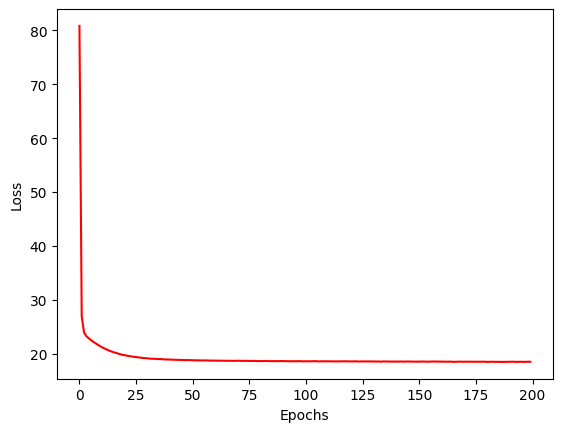

In [20]:
plt.plot(history['train_loss'],color="red")
plt.xlabel('Epochs')
plt.ylabel('Loss')


Text(0, 0.5, 'kendall_error')

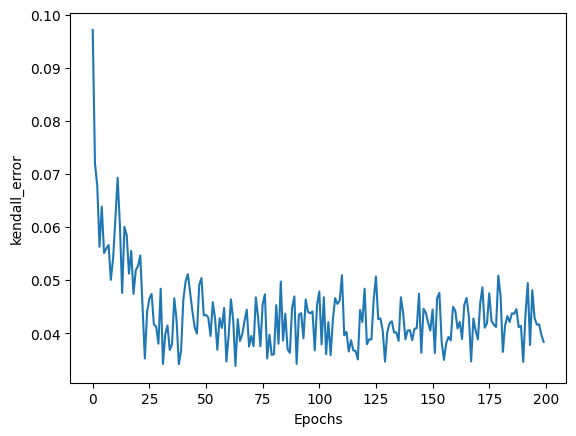

In [21]:
plt.plot(history['kendall'])
plt.xlabel('Epochs')
plt.ylabel('kendall_error')

Text(0, 0.5, 'anderson darling')

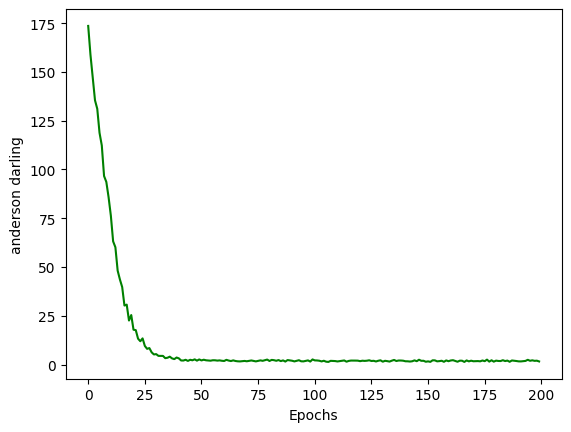

In [22]:
plt.plot(history['anderson'],color="green")
plt.xlabel('Epochs')
plt.ylabel('anderson darling')

# Results

In [23]:
df = pd.read_csv("/kaggle/input/ganproject/data_train_log_return.csv",header=None,sep=',',index_col=0)
data2 = df.values

In [24]:
input_data = torch.from_numpy(data2).to(torch.float32)
input_data = input_data.to(device)
z,_,_ = model(input_data)
samples,x = model.sample(746,device)
anderson_metric,kendall_error = ad(input_data,x),kd(input_data,x)
print(f"anderson_metric: {anderson_metric:.4f}\t kendall_error: {kendall_error:.4f}")

anderson_metric: 1.2209	 kendall_error: 0.0129


In [25]:
samples  = samples.detach().cpu().numpy()
z = z.detach().cpu().numpy()
x = x.detach().cpu().numpy()

[Text(0.5, 1.0, 'Generated data space X'), None, Text(0, 0.5, 'y')]

<Figure size 1500x1000 with 0 Axes>

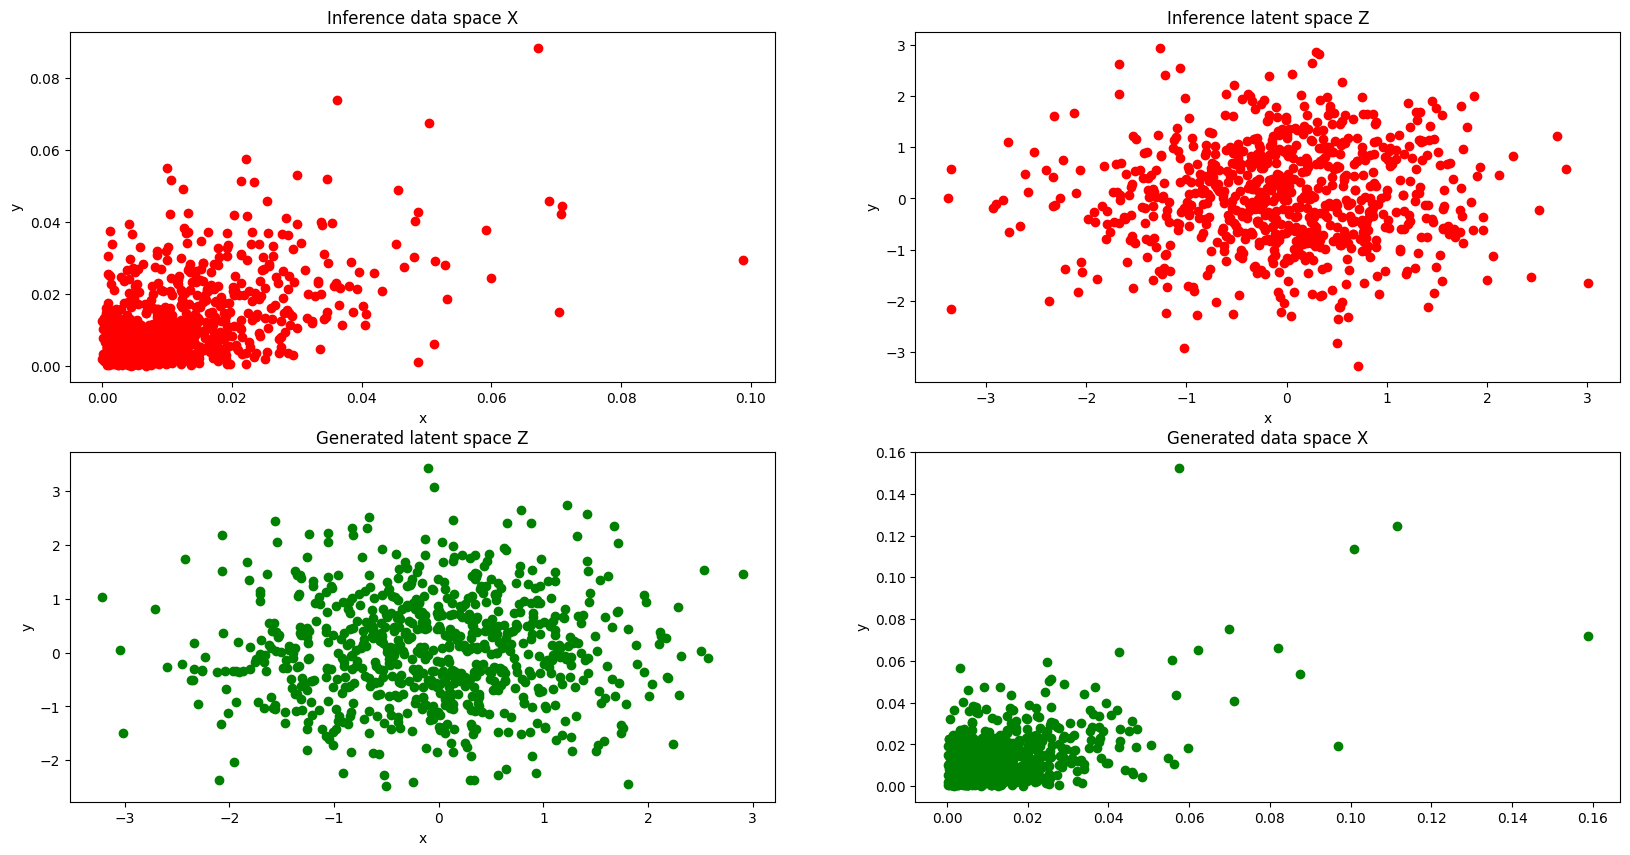

In [26]:
plt.figure(figsize=(15, 10))
f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 10)
axes[0, 0].scatter(data2[:, 0], data2[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")


In [27]:
final_df = pd.DataFrame(x)
final_df.describe()

,0,1,2,3
count,746.000000,746.000000,746.000000,746.000000
mean,0.013291,0.013014,0.010043,0.011484
std,0.014200,0.013680,0.011260,0.011026
min,0.000126,0.000183,0.000063,0.000052
25%,0.004613,0.004290,0.003244,0.004230
50%,0.009388,0.009451,0.007035,0.008514
75%,0.017199,0.017844,0.012776,0.014772
max,0.158787,0.152503,0.101971,0.080352


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


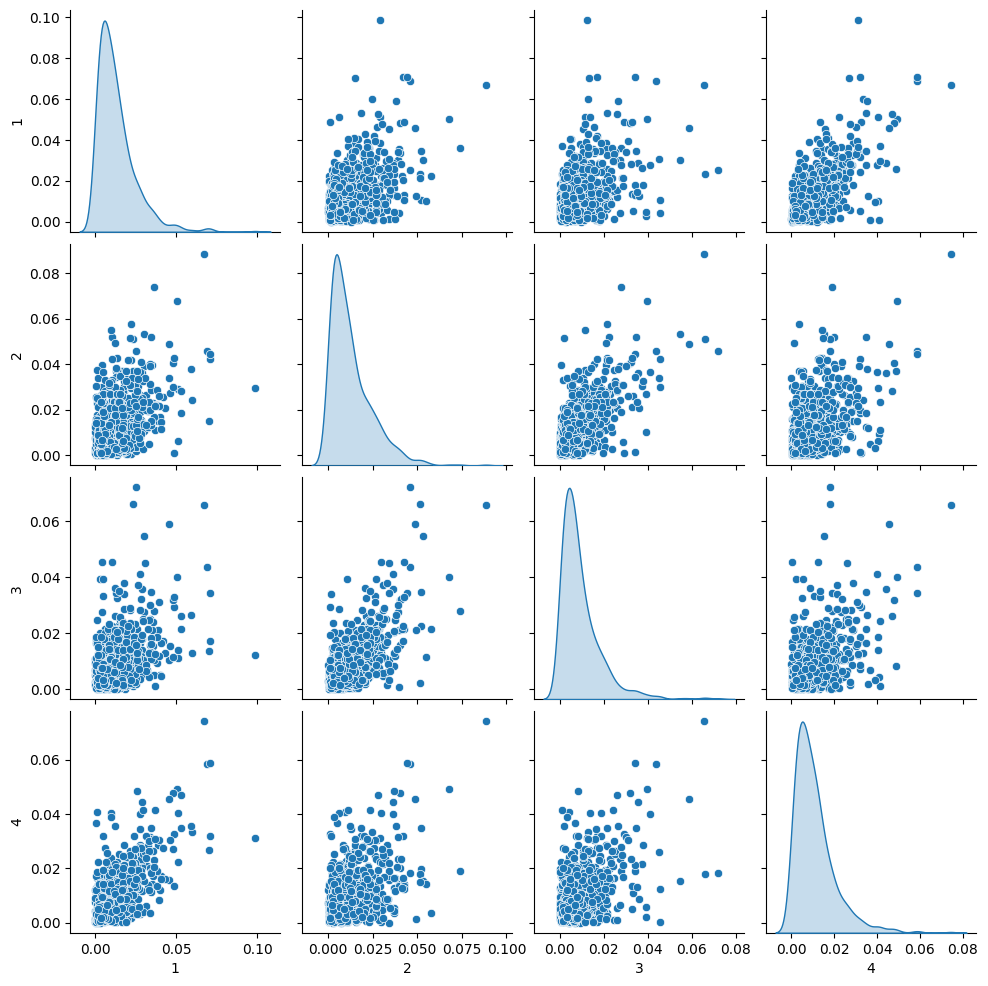

In [28]:
import seaborn as sns
sns.pairplot(df,diag_kind="kde")

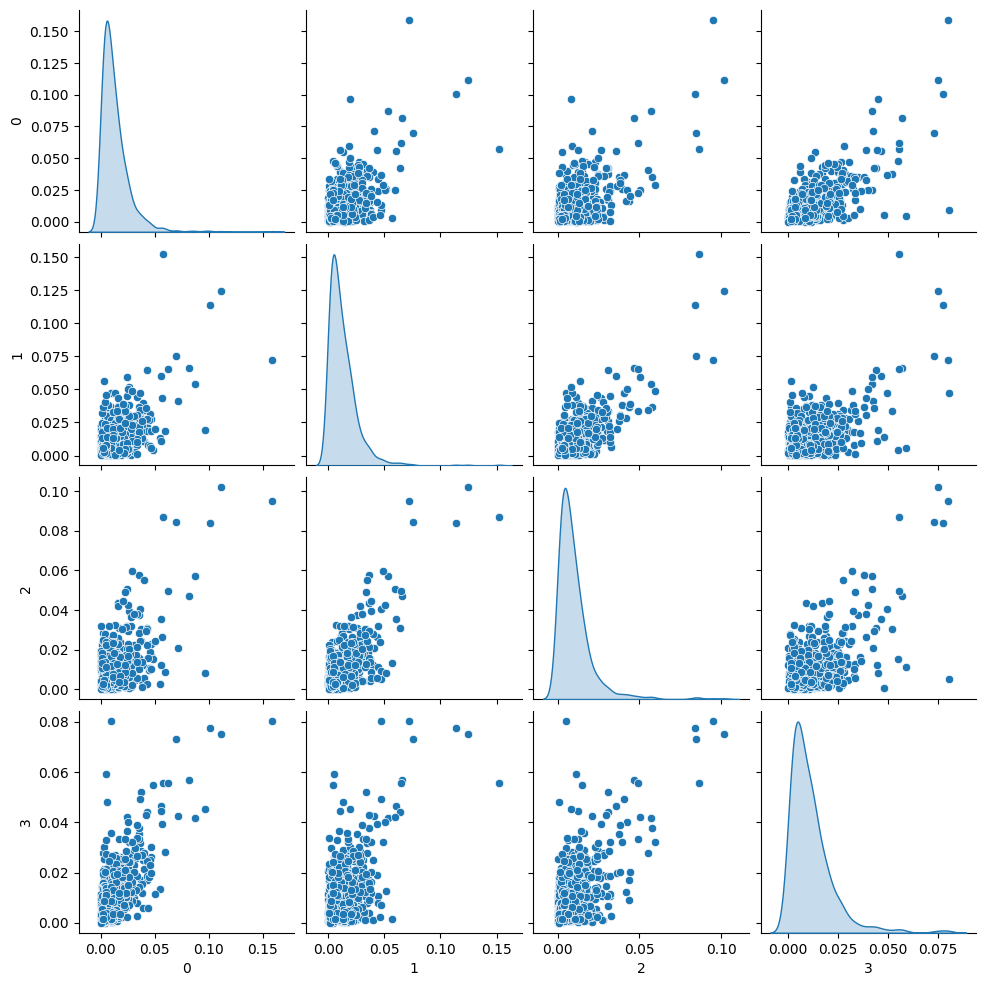

In [29]:
sns.pairplot(final_df,diag_kind="kde")

<Axes: >

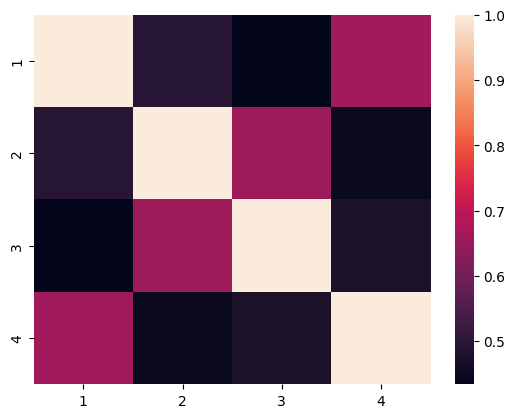

In [30]:
sns.heatmap(df.corr())

<Axes: >

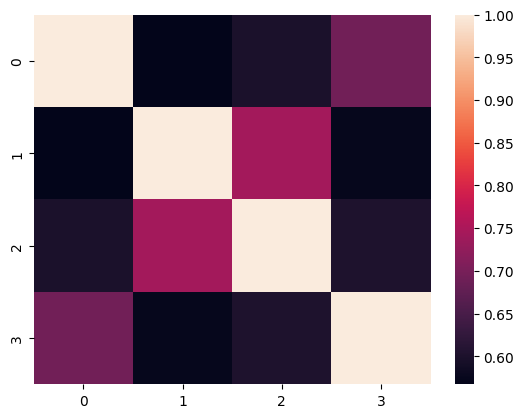

In [31]:
sns.heatmap(final_df.corr())

In [32]:
torch.save(model.state_dict(), f"RealNVP_model.pt")